In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Đọc dữ liệu

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NMKHDL/anime_preprocessing.csv')
df.head()

,ID,Title,Episodes,Type,Aired,Producers,Studios,Source,Genres,Duration (mins),Score,Scored By,Rank,Popularity,Year
0,1.0,Cowboy Bebop,26.0,TV,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Sunrise,Original,"Action, Award Winning, Sci-Fi",24.0,8.75,988000.0,482.0,43.0,1998.0
1,5.0,Cowboy Bebop: Tengoku no Tobira,1.0,Movie,"Sep 1, 2001","Sunrise, Bandai Visual",Bones,Original,"Action, Sci-Fi",115.0,8.38,219779.0,2092.0,631.0,2001.0
2,6.0,Trigun,26.0,TV,"Apr 1, 1998 to Sep 30, 1998",Victor Entertainment,Madhouse,Manga,"Action, Adventure, Sci-Fi",24.0,8.22,380049.0,3602.0,258.0,1998.0
3,7.0,Witch Hunter Robin,26.0,TV,"Jul 3, 2002 to Dec 25, 2002","Bandai Visual, Dentsu, Victor Entertainment",Sunrise,Original,"Action, Drama, Mystery, Supernatural",25.0,7.24,44600.0,30982.0,1908.0,2002.0
4,8.0,Bouken Ou Beet,52.0,TV,"Sep 30, 2004 to Sep 29, 2005","TV Tokyo, Dentsu",Toei Animation,Manga,"Action, Adventure, Fantasy",23.0,6.93,6891.0,45862.0,5485.0,2004.0


# Tiền xử lý dữ liệu

Sau quá trình đặt và trả lời câu hỏi, nhóm đã lựa chọn những thuộc tính quan trọng ảnh hưởng đến điểm của Anime: thời lượng (Duration), thể loại (Genres) và nguồn (Source). Do đó ta xóa các cột khác.

In [ ]:
df = df.drop(columns=['Title', 'Episodes', 'Aired', 'Rank', 'Popularity', 'Scored By', 'Year', 'Studios', 'Producers'])

In [ ]:
na_counts = df.isnull().sum()
print(na_counts)

ID                  0
Type                0
Source              0
Genres              0
Duration (mins)    15
Score               0
dtype: int64


In [ ]:
df = df.dropna(subset=['Duration (mins)'])

In [ ]:
na_counts = df.isnull().sum()
print(na_counts)

ID                 0
Type               0
Source             0
Genres             0
Duration (mins)    0
Score              0
dtype: int64


In [ ]:
df = df[~df['Source'].str.contains('UNKNOWN', na=False)]
df = df[~df['Type'].str.contains('UNKNOWN', na=False)]
df = df[~df['Genres'].apply(lambda x: 'UNKNOWN' in x)]

In [ ]:
df.head()

,ID,Type,Source,Genres,Duration (mins),Score
0,1.0,TV,Original,"Action, Award Winning, Sci-Fi",24.0,8.75
1,5.0,Movie,Original,"Action, Sci-Fi",115.0,8.38
2,6.0,TV,Manga,"Action, Adventure, Sci-Fi",24.0,8.22
3,7.0,TV,Original,"Action, Drama, Mystery, Supernatural",25.0,7.24
4,8.0,TV,Manga,"Action, Adventure, Fantasy",23.0,6.93


One-hot encoding cho thuộc tính Genres

Label Encoder cho Source

In [ ]:
df['Source'] = df['Source'].astype('category').cat.codes
df['Type'] = df['Type'].astype('category').cat.codes

for col in ['Genres']:
    df[col] = df[col].fillna("").apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])
    ohe_df = pd.get_dummies(df[col].apply(pd.Series).stack()).groupby(level=0).sum()
    df = pd.concat([df, ohe_df], axis=1)

# Xóa các cột ban đầu nếu không cần thiết
df = df.drop(columns=['Genres'])

# Chuẩn bị dữ liệu cho mô hình
X = df.drop(columns=['ID', 'Score'])
y = df['Score']

In [ ]:
X

,Type,Source,Duration (mins),Action,Adventure,Avant Garde,Award Winning,Boys Love,Comedy,Drama,...,Gourmet,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,7,9,24.0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,9,115.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7,5,24.0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7,9,25.0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,7,5,23.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16925,3,15,19.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16926,3,5,17.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
16928,7,4,23.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16929,7,14,10.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


# Kiểm tra phân phối dữ liệu

In [ ]:
print(y.describe())

count    8392.000000
mean        6.689608
std         0.853304
min         2.000000
25%         6.140000
50%         6.700000
75%         7.270000
max         9.320000
Name: Score, dtype: float64


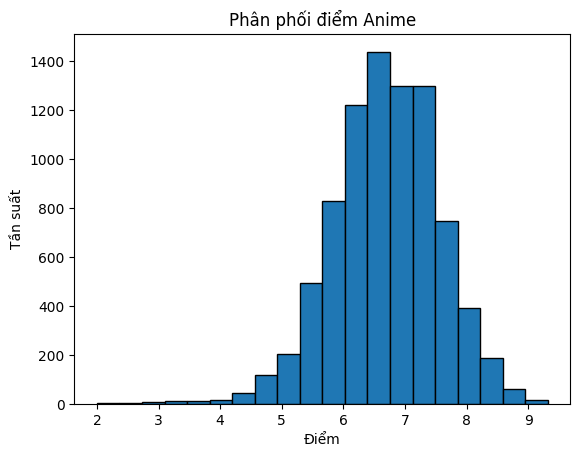

In [ ]:
# Vẽ biểu đồ histogram
y.plot(kind='hist', bins=20, edgecolor='black')
plt.title('Phân phối điểm Anime')
plt.xlabel('Điểm')
plt.ylabel('Tần suất')
plt.show()


In [ ]:
from scipy.stats import skew

# Tính skewness
skewness = skew(y)
print(f"Skewness: {skewness}")

Skewness: -0.32843227715505796


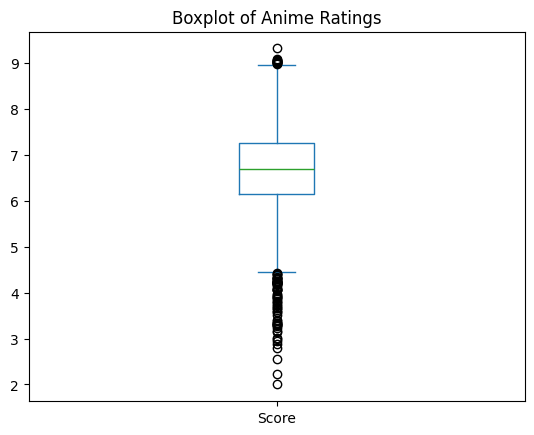

In [ ]:
y.plot(kind='box')
plt.title('Boxplot of Anime Ratings')
plt.show()

In [ ]:
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

# Lọc ngoại lệ
outliers = y[(y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR))]
print(outliers)


387      2.23
716      4.30
741      9.01
1002     4.43
1490     4.22
         ... 
13882    9.01
14089    3.80
14372    9.00
16084    9.32
16882    9.06
Name: Score, Length: 84, dtype: float64


Dữ liệu có phân phối khá gần phân phối chuẩn, khá cân bằng và có tỉ lệ giá trị ngoại lệ thấp.

# Chuẩn hóa dữ liệu

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
print("Check for NaN in X:", np.isnan(X).any())
print("Check for NaN in y:", np.isnan(y).any())

Check for NaN in X: False
Check for NaN in y: False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng mô hình

In [ ]:
results = []

In [ ]:
def train_model(model, model_name):
  model.fit(X_train, y_train)
  # Predict
  y_pred = model.predict(X_test)
  # Evaluate
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)
  result = {
    'Model': model_name,
    'MSE': mse,
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2
  }
  return result

## Phương pháp cơ sở: Linear Regression từ thư viện Scikit-learn. Trong scikit-learn, lớp Linear Regression sử dụng phương pháp Ordinary Least Squares (OLS) để tối ưu hóa mô hình hồi quy tuyến tính.

In [ ]:
model = LinearRegression()
# Train model
result = train_model(model, "Linear Regression")
print(result)
results.append(result)

{'Model': 'Linear Regression', 'MSE': 0.6140165489874092, 'MAE': 0.6157813712589633, 'RMSE': 0.7835920807329597, 'R²': 0.19376990220135804}


## Decision Tree

In [ ]:
model = DecisionTreeRegressor(random_state=42)
result = train_model(model, 'Decision Tree')
print(result)
results.append(result)

{'Model': 'Decision Tree', 'MSE': 0.7666177854909793, 'MAE': 0.6537548104769998, 'RMSE': 0.8755671222076462, 'R²': -0.006602074797245283}


## Random Forest

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
result = train_model(model, 'Random Forest')
print(result)
results.append(result)

{'Model': 'Random Forest', 'MSE': 0.4958143363315312, 'MAE': 0.5380164470444386, 'RMSE': 0.704140849781868, 'R²': 0.348974483619763}


## AdaBoost

In [ ]:
model = AdaBoostRegressor(n_estimators=100, random_state=42)
result = train_model(model, 'Adaboost')
print(result)
results.append(result)

{'Model': 'Adaboost', 'MSE': 0.5943476522098173, 'MAE': 0.606607710939841, 'RMSE': 0.7709394607943073, 'R²': 0.21959600835230886}


## GradientBoosting

In [ ]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
result = train_model(model, 'Gradient Boosting')
print(result)
results.append(result)

{'Model': 'Gradient Boosting', 'MSE': 0.4918744482826961, 'MAE': 0.5486470934985936, 'RMSE': 0.7013376136232079, 'R²': 0.35414772582661624}


## XGBoost

In [ ]:
model = XGBRegressor(n_estimators=100, random_state=42)
result = train_model(model, 'XGBoost')
print(result)
results.append(result)

{'Model': 'Extreme Gradient Boosting', 'MSE': 0.45449515349897096, 'MAE': 0.5206015816098384, 'RMSE': 0.6741625571766582, 'R²': 0.4032283451337434}


## Stacking

In [ ]:
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
]
model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
result = train_model(model, 'Stacking')
print(result)
results.append(result)

{'Model': 'Stacking', 'MSE': 0.44764806043323474, 'MAE': 0.5185275011513747, 'RMSE': 0.6690650644244062, 'R²': 0.4122188723778847}


## Vẽ kết quả

In [ ]:
results

[{'Model': 'Linear Regression',
  'MSE': 0.6140165489874092,
  'MAE': 0.6157813712589633,
  'RMSE': 0.7835920807329597,
  'R²': 0.19376990220135804},
 {'Model': 'Decision Tree',
  'MSE': 0.7666177854909793,
  'MAE': 0.6537548104769998,
  'RMSE': 0.8755671222076462,
  'R²': -0.006602074797245283},
 {'Model': 'Random Forest',
  'MSE': 0.4958143363315312,
  'MAE': 0.5380164470444386,
  'RMSE': 0.704140849781868,
  'R²': 0.348974483619763},
 {'Model': 'Adaboost',
  'MSE': 0.5943476522098173,
  'MAE': 0.606607710939841,
  'RMSE': 0.7709394607943073,
  'R²': 0.21959600835230886},
 {'Model': 'Gradient Boosting',
  'MSE': 0.4918744482826961,
  'MAE': 0.5486470934985936,
  'RMSE': 0.7013376136232079,
  'R²': 0.35414772582661624},
 {'Model': 'Extreme Gradient Boosting',
  'MSE': 0.45449515349897096,
  'MAE': 0.5206015816098384,
  'RMSE': 0.6741625571766582,
  'R²': 0.4032283451337434},
 {'Model': 'Stacking',
  'MSE': 0.44764806043323474,
  'MAE': 0.5185275011513747,
  'RMSE': 0.6690650644244062,

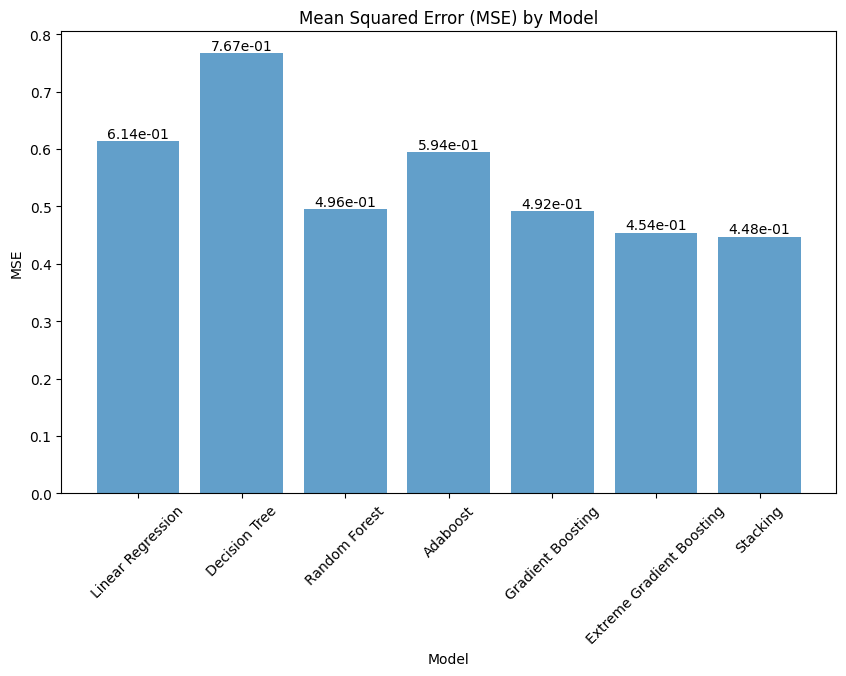

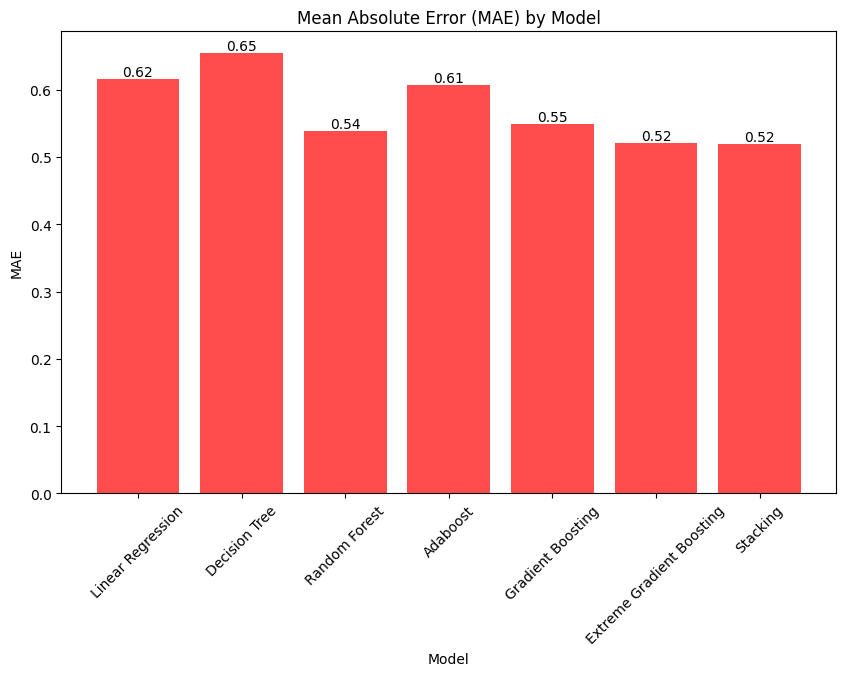

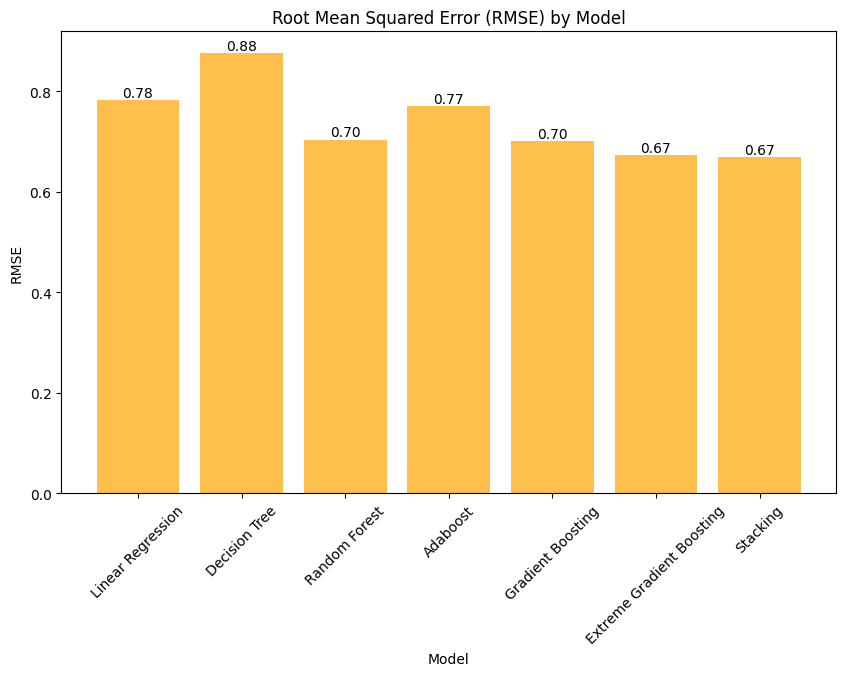

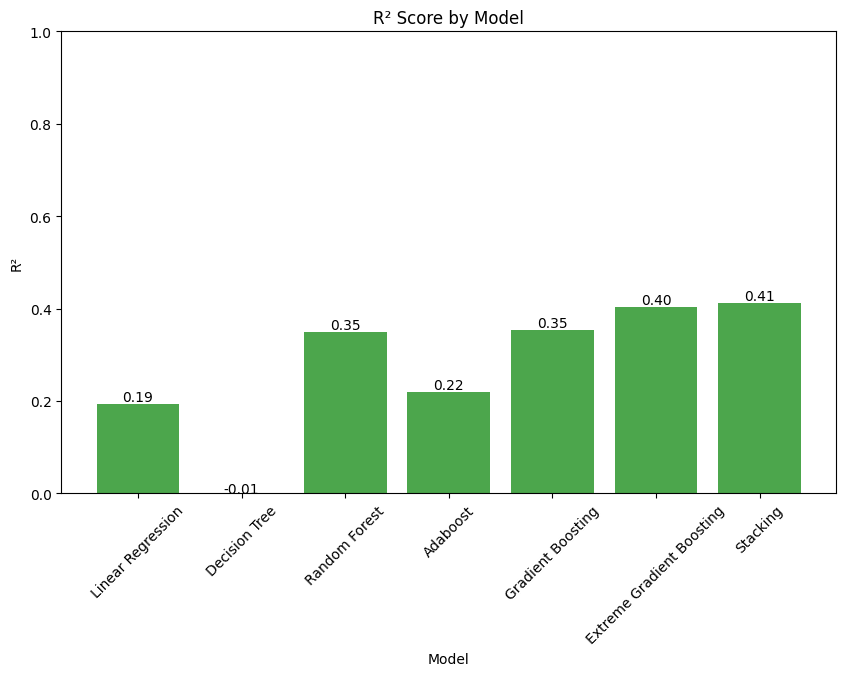

In [ ]:
def plot_result(metric):
  plt.figure(figsize=(10, 6))
  plt.bar(results_df['Model'], results_df[metric], alpha=0.7)
  plt.title(f'{metric}')
  plt.ylabel(f'{metric}')
  plt.xlabel('Model')
  plt.xticks(rotation=45)

  for index, value in enumerate(results_df[metric]):
      plt.text(index, value, f"{value:.2e}", ha='center', va='bottom')
  plt.show()


results_df = pd.DataFrame(results)


# MSE
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['MSE'], alpha=0.7)
plt.title('Mean Squared Error (MSE) by Model')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.xticks(rotation=45)

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['MSE']):
    plt.text(index, value, f"{value:.2e}", ha='center', va='bottom')

plt.show()

# MAE
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['MAE'], alpha=0.7, color='red')
plt.title('Mean Absolute Error (MAE) by Model')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.xticks(rotation=45)

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['MAE']):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.show()


# RMSE
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['RMSE'], alpha=0.7, color='orange')
plt.title('Root Mean Squared Error (RMSE) by Model')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['RMSE']):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.show()

# R²
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['R²'], alpha=0.7, color='green')
plt.title('R² Score by Model')
plt.ylabel('R²')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1 cho R²

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['R²']):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.show()


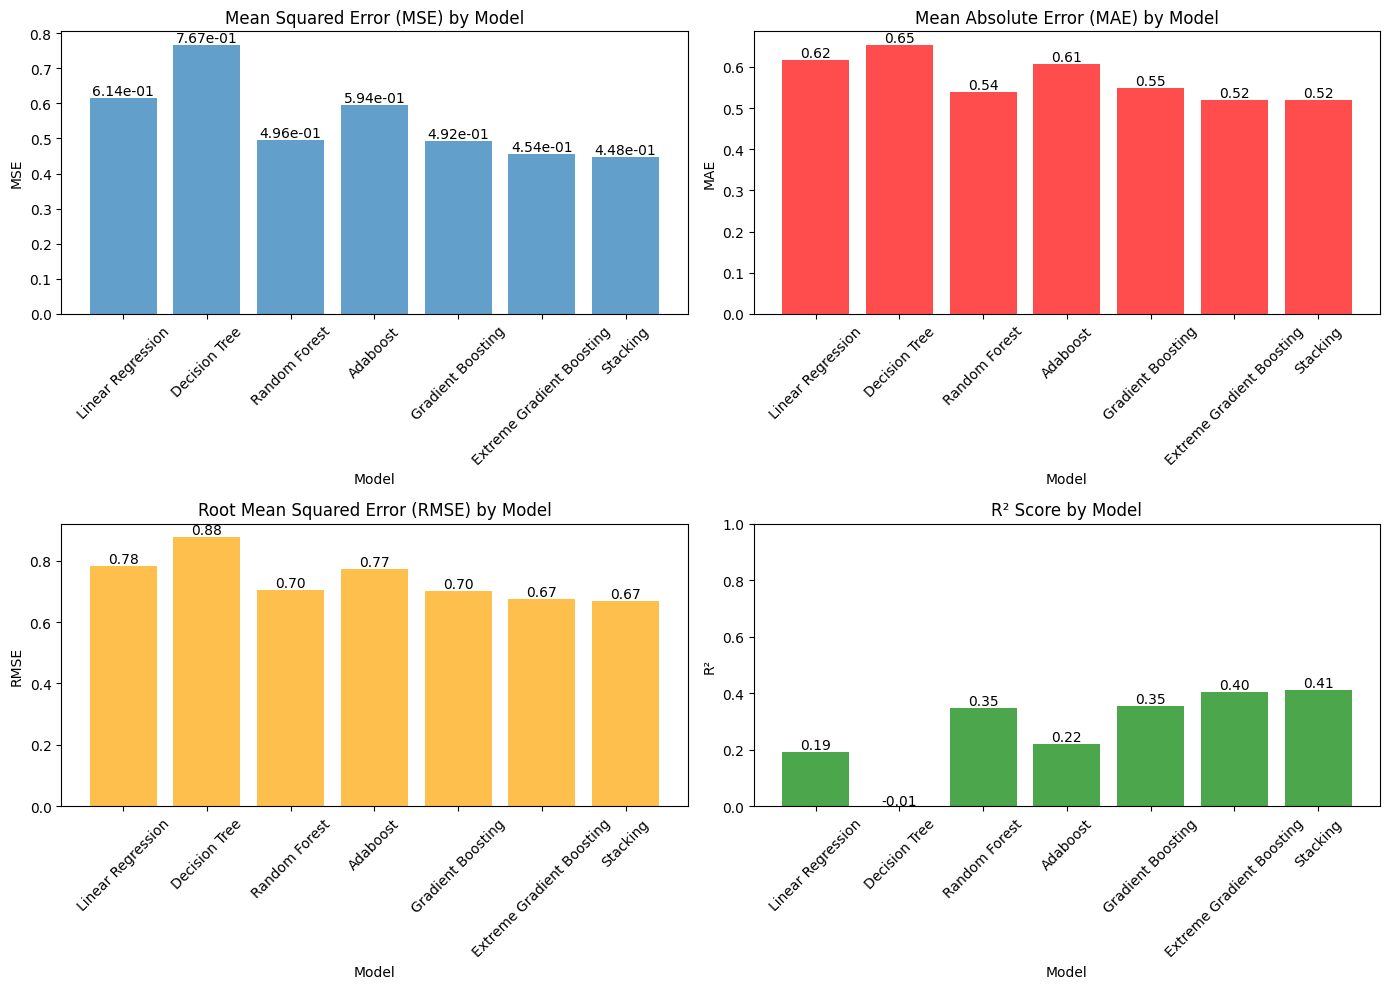

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Tạo dữ liệu mẫu
# results_df = pd.DataFrame(results)  # Uncomment and use your actual data

# Tạo figure và các axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Tạo lưới 2x2

# MSE
axs[0, 0].bar(results_df['Model'], results_df['MSE'], alpha=0.7)
axs[0, 0].set_title('Mean Squared Error (MSE) by Model')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].set_xlabel('Model')
axs[0, 0].tick_params(axis='x', rotation=45)

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['MSE']):
    axs[0, 0].text(index, value, f"{value:.2e}", ha='center', va='bottom')

# MAE
axs[0, 1].bar(results_df['Model'], results_df['MAE'], alpha=0.7, color='red')
axs[0, 1].set_title('Mean Absolute Error (MAE) by Model')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_xlabel('Model')
axs[0, 1].tick_params(axis='x', rotation=45)

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['MAE']):
    axs[0, 1].text(index, value, f"{value:.2f}", ha='center', va='bottom')

# RMSE
axs[1, 0].bar(results_df['Model'], results_df['RMSE'], alpha=0.7, color='orange')
axs[1, 0].set_title('Root Mean Squared Error (RMSE) by Model')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].set_xlabel('Model')
axs[1, 0].tick_params(axis='x', rotation=45)

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['RMSE']):
    axs[1, 0].text(index, value, f"{value:.2f}", ha='center', va='bottom')

# R²
axs[1, 1].bar(results_df['Model'], results_df['R²'], alpha=0.7, color='green')
axs[1, 1].set_title('R² Score by Model')
axs[1, 1].set_ylabel('R²')
axs[1, 1].set_xlabel('Model')
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].set_ylim(0, 1)  # Giới hạn từ 0 đến 1 cho R²

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['R²']):
    axs[1, 1].text(index, value, f"{value:.2f}", ha='center', va='bottom')

# Tinh chỉnh bố cục
plt.tight_layout()

# Hiển thị
plt.show()


In [ ]:
plot